# Questão 2
Utilize redes neurais perceptrons de múltiplas camadas para aproximar as funções baixo. Para o caso dos itens 2 e 3, apresente a curva da função analítica e a curva da função aproximada pela rede neural. Apresente também a curva do erro médio de treinamento com relação ao número de épocas e a curva do erro médio com o conjunto de validação. Procure definir para cada função a arquitetura da rede neural perceptron, isto é, o número de entradas, o número de neurônios em cada camada e o número de neurônios na camada de saída.
1. $f(x_{1}, x_{2}, x_{3}) = x_{1}\oplus x_{2}\oplus x_{3} \;\; x_{1}, x_{2} \text{ e } x_{3} \in \left\{0, 1\right\}$


2. $f(x) = \dfrac{\cos 2\pi x}{1-(4x)^{2}} \dfrac{\sin(\pi x)}{\pi x} \;\;,0\leq x \leq 4\pi$


3. $f(x_{1}, x_{2}) = x_{1}^{2} + x_{2}^{2} + 2x_{1}x_{2}\cos (\pi x_{1}x_{2}) + x_{1}+x_{2}-1 \;\;,|x_{1}|\leq 1 \text{ e } |x_{2}|\leq 1$

Logo abaixo estão as bibliotecas e funções comuns a solução de todos os itens.

In [1]:
import numpy as np
import itertools
import keras.callbacks as kc
import keras.layers as kl
import keras.models as km
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


## Solução da função 1 (TODO)
Vamos gerar nossos dados de treinamento e dados de validação manualmente. A função é bem simples e só admite 8 combinações de 0's e 1's.
Separaremos da seguinte forma, escolhida aleatoriamente:

<table>
  <tl>
      <td>Entradas</td>
      <td>Função</td>
  </tl>
  <tr>
    <td>000</td>
    <td>Treino</td>
  </tr>
  <tr>
    <td>001</td>
    <td>Treino</td>
  </tr>
  <tr>
    <td>010</td>
    <td>Validação</td>
  </tr>
  <tr>
    <td>011</td>
    <td>Treino</td>
  </tr>
  <tr>
    <td>100</td>
    <td>Treino</td>
  </tr>
  <tr>
    <td>101</td>
    <td>Treino</td>
  </tr>
  <tr>
    <td>110</td>
    <td>Validação</td>
  </tr>
  <tr>
    <td>111</td>
    <td>Treino</td>
  </tr>
</table>

### Construção dos vetores de treino e validação.
`x_treino` e `y_treino` serão os dados usados para treinar a rede. Já `x_teste` e `y_teste` serão usados para valida-la.

## Solução da função 2
Fazer regressão não linear não é tão simples assim. Por isso, faremos uso de uma classe do Keras chamada `KerasRegressor` para nos auxiliar nesta tarefa. Primeiro vamos deixar tudo pronto para usá-la definindo a função que queremos simular e o `modelo()` da rede neural.

In [2]:
qtd_ponto = 300  # QUANTIDADE DE PONTOS
def objetivo(x):
    return np.cos(2*np.pi*x)*np.sinc(x)/(1-(4*x)**2)

def modelo():
    model= km.Sequential()
    model.add(kl.Dense(20, input_dim=1, kernel_initializer='normal',activation='relu'))
    model.add(kl.Dense(20, kernel_initializer='normal',activation='relu'))
    model.add(kl.Dense(20, kernel_initializer='normal',activation='relu'))
    model.add(kl.Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

### Criando dados de treinamento
A rede neural que estamos contruindo deve retornar os valores da função dita anteriormente, logo, os dados de treinamento são valores de x quaisquer e valores calculados de $f(x)$.
O código abaixo criará o vetor com 400 valores de x no intervalo $[0, 4\pi]$ dispersos linearmente e o vetor y será preenchido com elementos $y_{i} = f(x_{i})$.

Os dados são escalados usando a classe StandardScaler().

OBS.: 
**Escalar** um vetor é soma-lo de uma constante e depois multiplica-lo por uma constante.
**Normalizar** um vetor é dividir todos elementos pela sua norma.
**Padronizar** um vetor geralmente significa subtrair um medida de localização (média) e dividir por uma medida de escala (desvio padrão).

Fonte: [Should I normalize/standardize/rescale the data?](http://www.faqs.org/faqs/ai-faq/neural-nets/part2/)

In [3]:
x = np.linspace(0, 4*np.pi, qtd_ponto)[np.newaxis].T  # cria um vetor coluna
y = objetivo(x)  # Também é vetor coluna
sc_X = StandardScaler()
sc_Y = StandardScaler()
x_treino = sc_X.fit_transform(x)
y_treino = sc_Y.fit_transform(y)

### Constuindo rede neural
Aqui criamos um objeto estimador. Seus parâmetros são: 

* Função que modela a rede
* Número de épocas: quantidade de vezes que ocorrerá o "backpropagation"
* Tamanho do "batch": quantidade de entradas testadas antes de atualizar os pesos
* verbose: um inteiro indicando o que deve ser impresso na tela, não é essencial ao projeto.

A função `fit()`, além de treinar a rede, retorna um histórico com os erros de cada época. Error neste contexto significa diferença entre saída e gabarito, que pode ser calculada de várias maneiras.

In [4]:
monitor = kc.EarlyStopping(monitor='loss', min_delta=0.5e-3, patience=2, verbose=0, mode='auto')  # Condição de parada do treinamento
estimador = KerasRegressor(build_fn=modelo, epochs=300, batch_size=4, verbose=1)  # quanto menor o batch-size, melhor a precisão do resultado
Hb =estimador.fit(x_treino, y_treino)

Epoch 1/300
300/300 [==============================] - 2s 6ms/step - loss: 0.9968
Epoch 2/300
300/300 [==============================] - 1s 2ms/step - loss: 0.9723
Epoch 3/300
300/300 [==============================] - 1s 2ms/step - loss: 0.9605
Epoch 4/300
300/300 [==============================] - 1s 2ms/step - loss: 0.9508
Epoch 5/300
300/300 [==============================] - 1s 3ms/step - loss: 0.9413
Epoch 6/300
300/300 [==============================] - 1s 2ms/step - loss: 0.9324
Epoch 7/300
300/300 [==============================] - 1s 2ms/step - loss: 0.9102
Epoch 8/300
300/300 [==============================] - 1s 2ms/step - loss: 0.8651
Epoch 9/300
300/300 [==============================] - 1s 2ms/step - loss: 0.8649
Epoch 10/300
300/300 [==============================] - 1s 2ms/step - loss: 0.7884
Epoch 11/300
300/300 [==============================] - 1s 2ms/step - loss: 0.7308
Epoch 12/300
300/300 [==============================] - 1s 2ms/step - loss: 0.6846
Epoch 13/300


300/300 [==============================] - 0s 969us/step - loss: 0.0514
Epoch 100/300
300/300 [==============================] - 0s 923us/step - loss: 0.0365
Epoch 101/300
300/300 [==============================] - 0s 849us/step - loss: 0.0099
Epoch 102/300
300/300 [==============================] - 0s 1ms/step - loss: 0.0533
Epoch 103/300
300/300 [==============================] - 0s 1ms/step - loss: 0.0583
Epoch 104/300
300/300 [==============================] - 0s 837us/step - loss: 0.1179
Epoch 105/300
300/300 [==============================] - 0s 830us/step - loss: 0.0490
Epoch 106/300
300/300 [==============================] - 0s 956us/step - loss: 0.0154
Epoch 107/300
300/300 [==============================] - 0s 827us/step - loss: 0.0021
Epoch 108/300
300/300 [==============================] - 0s 805us/step - loss: 0.0059
Epoch 109/300
300/300 [==============================] - 0s 861us/step - loss: 0.0048
Epoch 110/300
300/300 [==============================] - 0s 875us/step -

300/300 [==============================] - 1s 2ms/step - loss: 0.0091
Epoch 196/300
300/300 [==============================] - 1s 2ms/step - loss: 0.0551
Epoch 197/300
300/300 [==============================] - 1s 2ms/step - loss: 0.0127
Epoch 198/300
300/300 [==============================] - 1s 2ms/step - loss: 0.0315
Epoch 199/300
300/300 [==============================] - 1s 2ms/step - loss: 0.0490
Epoch 200/300
300/300 [==============================] - 1s 2ms/step - loss: 0.0017
Epoch 201/300
300/300 [==============================] - 1s 2ms/step - loss: 0.0016
Epoch 202/300
300/300 [==============================] - 1s 2ms/step - loss: 6.6290e-04
Epoch 203/300
300/300 [==============================] - 1s 2ms/step - loss: 0.0022
Epoch 204/300
300/300 [==============================] - 1s 2ms/step - loss: 0.0570
Epoch 205/300
300/300 [==============================] - 1s 2ms/step - loss: 0.3936
Epoch 206/300
300/300 [==============================] - 1s 2ms/step - loss: 0.0660
Ep

300/300 [==============================] - 0s 971us/step - loss: 0.0383
Epoch 292/300
300/300 [==============================] - 0s 1ms/step - loss: 0.1756
Epoch 293/300
300/300 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 294/300
300/300 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 295/300
300/300 [==============================] - 0s 932us/step - loss: 0.0095
Epoch 296/300
300/300 [==============================] - 0s 874us/step - loss: 0.0053
Epoch 297/300
300/300 [==============================] - 0s 966us/step - loss: 0.0011
Epoch 298/300
300/300 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 299/300
300/300 [==============================] - 0s 931us/step - loss: 0.0033
Epoch 300/300
300/300 [==============================] - 0s 1ms/step - loss: 5.7795e-04


### Validação
Mostramos o progresso do erro conforme se passam as épocas.

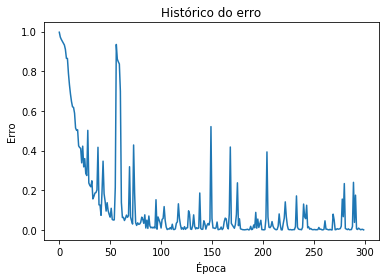

In [5]:
plt.plot(Hb.history['loss'])
plt.xlabel('Época')
plt.ylabel('Erro')
plt.title('Histórico do erro')
plt.show()

Criando dados para validação

In [6]:
interv = (x[1] - x[0])/2  # Metade do intervalo entre dois pontos em x_treino
x = np.linspace(interv, 4*np.pi+interv, qtd_ponto)[np.newaxis].T
y = objetivo(x)
x_teste = sc_X.fit_transform(x)
y_teste = sc_Y.fit_transform(y)

Visualizando resultado. Curva em azul é o gabarito, a verde é o estimado pela rede neural.

300/300 [==============================] - 0s 568us/step


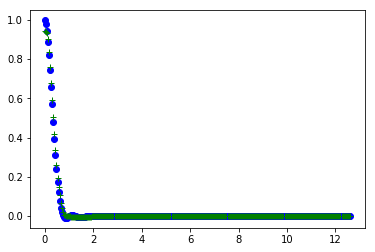

In [7]:
valores_norm = estimador.predict(x_teste)  # valores normalizados
valores = sc_Y.inverse_transform(valores_norm)

plt.plot(x, y, 'bo')
plt.plot(x, valores, 'g+')
plt.show()

## Solução da função 3
Vamos visualizar a função objetivo. No momento em que escrevi este trabalho o Google fornece uma visualização 3D da [função acima](https://www.google.com/search?client=ubuntu&channel=fs&q=z+%3D+x%5E2+%2B+y%5E2+%2B+2*x*y*cos%28pi*x*y%29+%2B+x+%2B+y+-+1&ie=utf-8&oe=utf-8).

In [8]:
from mpl_toolkits.mplot3d import Axes3D

def objetivo(x,y):
    return x**2 + y**2 + 2*x*y*np.cos(np.pi*x*y) + x + y - 1

def plotsuper(x,y,z, qtd_pts):
    #Plotando função objtetivo
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(x, y, z, cmap=plt.cm.viridis)
    plt.show()


x = np.linspace(-1, 1, qtd_pts)
y = np.random.rand(qtd_pts)*2-1
z = objetivo(x, y)
plotsuper(x,y,z,999)

NameError: name 'qtd_pts' is not defined

### Gerando dados de treinamento
Vamos criar um vetor de 100 pontos linearmente distribuídos no eixo x e um vetor com valores aleatórios representando as coordenadas y de cada ponto. O vetor z guarda o valor da função em cada ponto (x,y).

Os vetores precisam ter o formato de única coluna pois essa é a forma esperada pelo `Keras`. Por isso usamos a função `reshape(M, N)`, redimensionar o array para uma matriz de MxN. Note que só é obrigatório fornecer um dos valores, o outro é subentendido. Para omiti-lo, escrevemos -1 no lugar.

In [ ]:
x = np.linspace(-1, 1, qtd_pts).reshape(-1, 1)
y = np.random.rand(qtd_pts).reshape(-1, 1)*2-1
z = objetivo(x, y)

x = x.reshape(-1,1)
y = y.reshape(-1,1)
z = z.reshape(-1,1)

sc = StandardScaler()
x_treino = sc.fit_transform(x)
y_treino = sc.fit_transform(y)
z_treino = sc.fit_transform(z)

treino = []
for v1,v2 in zip(x_treino, y_treino):
    treino.append([v1[0], v2[0]])
treino = np.array(treino)


### Construindo rede neural

In [ ]:
def modelo():
    model = km.Sequential()
    model.add(kl.Dense(20, input_dim=2, kernel_initializer='normal',activation='relu'))
    model.add(kl.Dense(20, kernel_initializer='normal',activation='relu'))
    model.add(kl.Dense(20, kernel_initializer='normal',activation='relu'))
    model.add(kl.Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

monitor = kc.EarlyStopping(monitor='loss', min_delta=1e-4, patience=5, verbose=0, mode='auto')  # Condição de parada do treinamento
estimador = KerasRegressor(build_fn=modelo, epochs=150, batch_size=5, verbose=1, callbacks=[monitor])
Hc = estimador.fit(treino, z_treino)


### Validação
Vejamos o histórico de erro e depois o gráfico com os dados de teste.

In [ ]:
plt.plot(Hc.history['loss'])
plt.show()

In [ ]:
x = np.linspace(-1, 1, qtd_pts).reshape(-1 ,1)
y = np.random.rand(qtd_pts).reshape(-1, 1)*2-1
z = objetivo(x,y)

x_teste = sc.fit_transform(x)
y_teste = sc.fit_transform(y)
z_teste = sc.fit_transform(z)

teste = []
for v1,v2 in zip(x_teste,y_teste):
    teste.append([v1[0], v2[0]])
teste = np.array(teste)

valores_esc = estimador.predict(teste)
valores = sc.inverse_transform(valores_esc)

plotsuper(x.reshape(1,-1)[0], y.reshape(1,-1)[0], valores, 999)
